### Installing imortant libraries

In [ ]:
!pip install mplfinance 

In [44]:
import yfinance as yf
import pandas as pd
import pandas_datareader.data as web
import datetime
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, LSTM
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
import random
import mplfinance as mpf
import seaborn as sns

### Downloading historical stock and macro data

In [46]:
# Define the date range
start_date = "2015-01-01"
end_date = "2024-08-01"

# Fetch historical data for FTSE 250
ftse_250_data = yf.download("^FTMC", start=start_date, end=end_date).reset_index()
ftse_250_data['Date'] = ftse_250_data['Date'].dt.date

# Calculate Moving Average (MA)
ftse_250_data['MA_20'] = ftse_250_data['Close'].rolling(window=20).mean()


# Calculate Bollinger Bands
ftse_250_data['BB_Middle'] = ftse_250_data['Close'].rolling(window=20).mean()
ftse_250_data['BB_Upper'] = ftse_250_data['BB_Middle'] + 2 * ftse_250_data['Close'].rolling(window=20).std()
ftse_250_data['BB_Lower'] = ftse_250_data['BB_Middle'] - 2 * ftse_250_data['Close'].rolling(window=20).std()

# Calculate RSI (Relative Strength Index)
delta = ftse_250_data['Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
ftse_250_data['RSI'] = 100 - (100 / (1 + rs))

[*********************100%%**********************]  1 of 1 completed


### Data pre-processing

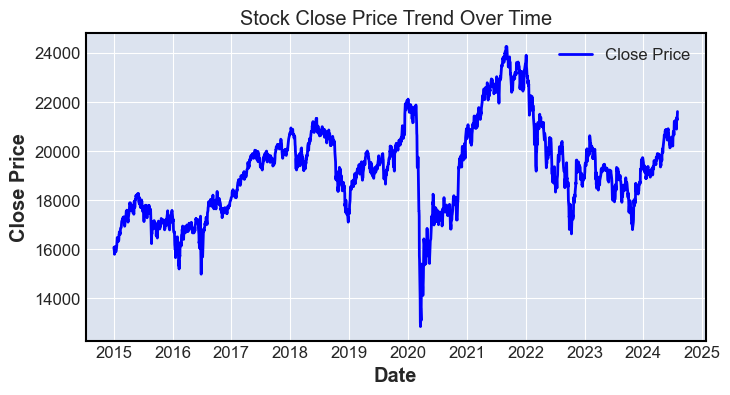

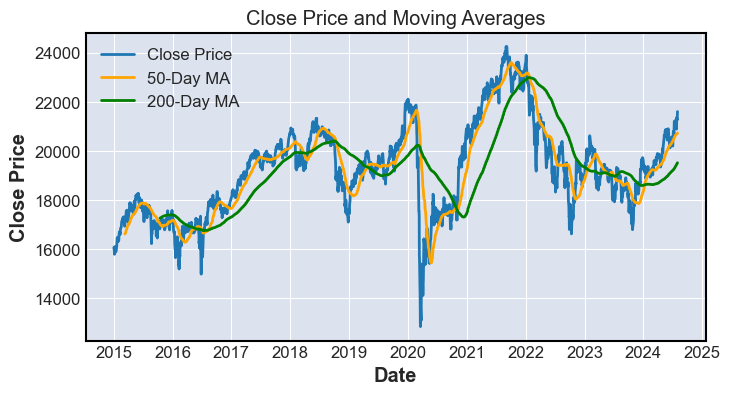

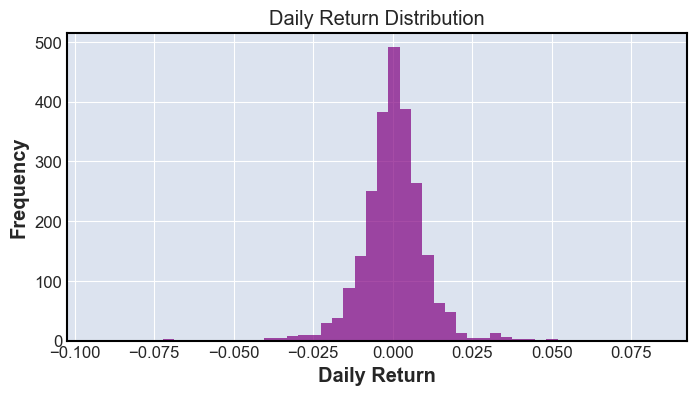

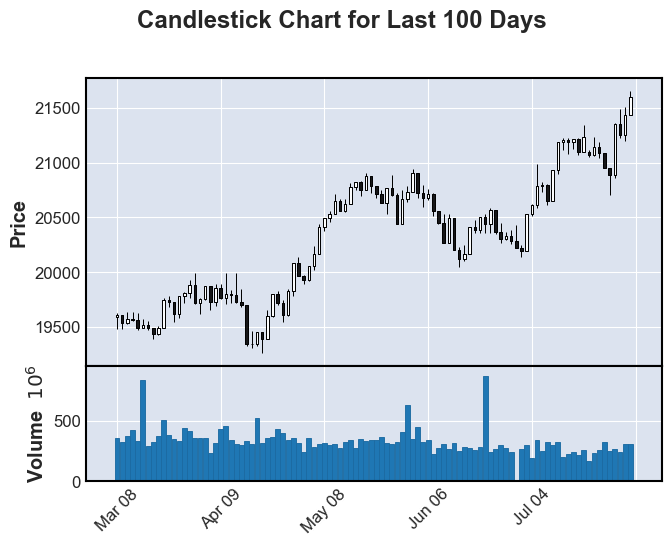

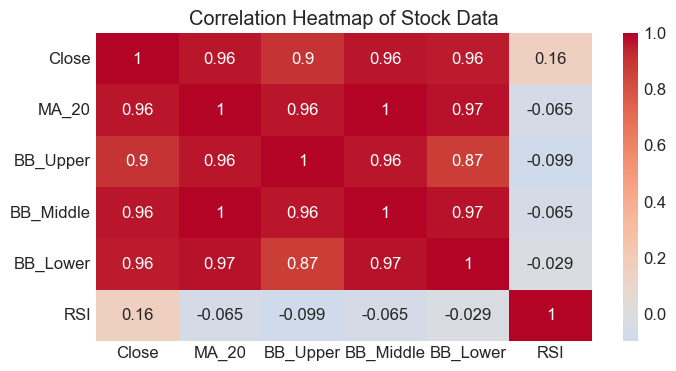

In [71]:


# copy data from ftse to df for preprocessing
df = ftse_250_data.copy()

# Summary statistics
summary_stats = df.describe()

# Plot closing price trend
plt.figure(figsize=(8,4))
plt.plot(df['Date'], df['Close'], color='blue', label='Close Price')
plt.title('Stock Close Price Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

# Moving averages
df['50_MA'] = df['Close'].rolling(window=50).mean()
df['200_MA'] = df['Close'].rolling(window=200).mean()

plt.figure(figsize=(8,4))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.plot(df['Date'], df['50_MA'], label='50-Day MA', color='orange')
plt.plot(df['Date'], df['200_MA'], label='200-Day MA', color='green')
plt.title('Close Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

# Daily returns
df['Daily_Return'] = df['Close'].pct_change()

plt.figure(figsize=(8,4))
plt.hist(df['Daily_Return'].dropna(), bins=50, color='purple', alpha=0.7)
plt.title('Daily Return Distribution')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Plot candlestick chart
mpf.plot(df[-100:], type='candle', volume=True, title='Candlestick Chart for Last 100 Days')

# Correlation heatmap
plt.figure(figsize=(8,4))
sns.heatmap(df[['Close', 'MA_20', 'BB_Upper', 'BB_Middle', 'BB_Lower', 'RSI']].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Stock Data')
plt.show()

In [49]:
# copy original ftse_250 data in new dataframe 'data' for feature engineering
data = ftse_250_data.copy()

In [50]:
# Dropping the NaN values at the end of the dataset
data = data.dropna()

In [51]:
# Setting 'Date' back to index
data.set_index('Date', inplace=True)

In [52]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume,MA_20,BB_Middle,BB_Upper,BB_Lower,RSI
count,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2.401000e+03,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000
mean,19250.627706,19358.280561,19145.083044,19252.845992,19252.845992,3.103931e+08,19233.089178,19233.089178,19839.718461,18626.459896,52.911853
std,1838.447150,1829.219371,1850.697734,1838.228534,1838.228534,1.163343e+08,1805.005389,1805.005389,1816.450408,1918.691839,16.677225
min,12829.700195,13035.099609,12373.500000,12829.700195,12829.700195,0.000000e+00,14512.940039,14512.940039,16320.518178,11176.858091,5.760384
25%,17781.400391,17876.800781,17676.599609,17782.400391,17782.400391,2.492824e+08,17731.960059,17731.960059,18295.326183,17232.530892,40.964258
50%,19272.699219,19367.400391,19172.000000,19273.300781,19273.300781,2.956945e+08,19236.515137,19236.515137,19834.509788,18751.937111,53.063420
75%,20316.400391,20432.500000,20231.500000,20320.400391,20320.400391,3.486970e+08,20272.430078,20272.430078,20912.521437,19657.846726,64.431300
max,24250.800781,24353.900391,24176.300781,24250.800781,24250.800781,1.231878e+09,23926.465137,23926.465137,24407.598624,23515.208028,94.870902


In [53]:
# Checking if 'Date' is in the index
if 'Date' in data.index.names:
  print("The index is 'Date'")
else:
  print("The index is not 'Date'")

The index is 'Date'


### Creating target variable

In [54]:
# Creating target variable y
window = 15
data['Target'] = data['Close'].shift(-window)

### Labelling the data

In [55]:
 # Labelling of data
def create_dataset_with_macro(data, window=15):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[['Close', 'MA_20', 'BB_Upper', 'BB_Lower', 'RSI']].iloc[i:i+window].values)
        y.append(data['Target'][i])
    return np.array(X), np.array(y)

### Splitting and scaling the data

In [56]:
# Data Splitting: Train-Test and validation Split
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.15)

train_data = data[:train_size]
val_data = data[train_size :train_size+val_size]
test_data = data[train_size+val_size:]

def rolling_min_max_scaling(train_data, val_data, test_data, window=15):
    scaler = MinMaxScaler()
    scaled_train_data = train_data.copy()
    scaled_val_data = val_data.copy()
    scaled_test_data = test_data.copy()

    # Scale training data
    for i in range(len(train_data)):
        start_idx = max(0, i - window + 1)
        end_idx = i + 1
        window_data = train_data[start_idx:end_idx]
        scaled_window = scaler.fit_transform(window_data)
        scaled_train_data.iloc[i] = scaled_window[-1]

    # Scale validation data
    for i in range(len(val_data)):
        start_idx = max(0, len(train_data) - window + 1)
        end_idx = len(train_data) + i + 1
        window_data = np.vstack((train_data[start_idx:], val_data.iloc[:i+1]))
        scaled_window = scaler.fit_transform(window_data)
        scaled_val_data.iloc[i] = scaled_window[-1]

    # Scale test data
    for i in range(len(test_data)):
        start_idx = max(0, len(train_data) + len(val_data) - window + 1)
        end_idx = len(train_data) + len(val_data) + i + 1
        window_data = np.vstack((train_data[-window:], val_data, test_data.iloc[:i+1]))
        scaled_window = scaler.fit_transform(window_data)
        scaled_test_data.iloc[i] = scaled_window[-1]

    return scaled_train_data, scaled_val_data, scaled_test_data, scaler


# Applying the scaling, selecting columns by name
selected_columns = ['Close', 'MA_20', 'BB_Upper', 'BB_Lower', 'RSI', 'Target']
scaled_train_data, scaled_val_data, scaled_test_data, scaler = rolling_min_max_scaling(
    train_data[selected_columns],
    val_data[selected_columns],
    test_data[selected_columns]
)

### Model building

In [57]:
# Set seeds
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [58]:
# Creating datasets
window_size = 15
X_train, y_train = create_dataset_with_macro(scaled_train_data[['Close', 'MA_20', 'BB_Upper', 'BB_Lower', 'RSI', 'Target']], window=window_size)
X_val, y_val = create_dataset_with_macro(scaled_val_data[['Close', 'MA_20', 'BB_Upper', 'BB_Lower', 'RSI', 'Target']], window=window_size)
X_test, y_test = create_dataset_with_macro(scaled_test_data[['Close', 'MA_20', 'BB_Upper', 'BB_Lower', 'RSI', 'Target']], window=window_size)

# Reshaping data for LSTM and CNN
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_val_lstm = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2]))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Reshaping data for CNN
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_val_cnn = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2]))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Display the shapes
print("\nTraining Data Shape:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

# Display the shapes
print("\nTesting Data Shape:")
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)


Training Data Shape:
X_train: (1665, 15, 5)
y_train: (1665,)

Testing Data Shape:
X_test: (346, 15, 5)
y_test: (346,)


### CNN Model

In [59]:
# CNN Model
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(window_size, X_train_cnn.shape[2])),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])
cnn_model.compile(optimizer='adam', loss='mean_squared_error')
history_cnn = cnn_model.fit(X_train_cnn, y_train, validation_data=(X_val_cnn, y_val),epochs=10, batch_size=16, verbose=0)

# Predict with CNN
cnn_predictions_scaled = cnn_model.predict(X_test_cnn)

close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = scaler.min_[0], scaler.scale_[0] # Extract the scaler for the 'Close' column

# Reverse Scaling for CNN
cnn_predictions = close_scaler.inverse_transform(cnn_predictions_scaled)

cnn_predictions = cnn_predictions[:, 0]

C:\Users\bhart\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


### LSTM Model

In [61]:
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(window_size, 5)),
    Dense(50, activation='relu'),
    Dense(1)
    ])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
history_lstm = lstm_model.fit(X_train_lstm, y_train, validation_data=(X_val_lstm, y_val),epochs=15, batch_size=16, verbose=0)

# Prediction with LSTM
lstm_predictions_scaled = lstm_model.predict(X_test_lstm)

close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = scaler.min_[0], scaler.scale_[0] # Extract the scaler for the 'Close' column

# Reverse Scaling for CNN
lstm_predictions = close_scaler.inverse_transform(lstm_predictions_scaled)

lstm_predictions = lstm_predictions[:, 0]

C:\Users\bhart\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


### ANN Model

In [63]:
ann_model = Sequential([
    Dense(100, activation='relu', input_shape=(X_train.shape[1] * X_train.shape[2],)),
    Dense(50, activation='relu'),
    Dense(1)
])
ann_model.compile(optimizer='adam', loss='mean_squared_error')
# Reshape X_val to match the input shape of the ANN
history_ann = ann_model.fit(X_train.reshape(X_train.shape[0], -1), y_train,
              validation_data=(X_val.reshape(X_val.shape[0], -1), y_val),
              epochs=8, batch_size=16, verbose=0)

# Predict with ANN
ann_predictions_scaled = ann_model.predict(X_test.reshape(X_test.shape[0], -1))

close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = scaler.min_[0], scaler.scale_[0] # Extract the scaler for the 'Close' column
# Reverse Scaling for ANN
ann_predictions = close_scaler.inverse_transform(ann_predictions_scaled)

ann_predictions = ann_predictions[:, 0]

C:\Users\bhart\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


### Plotting training and validation loss graph

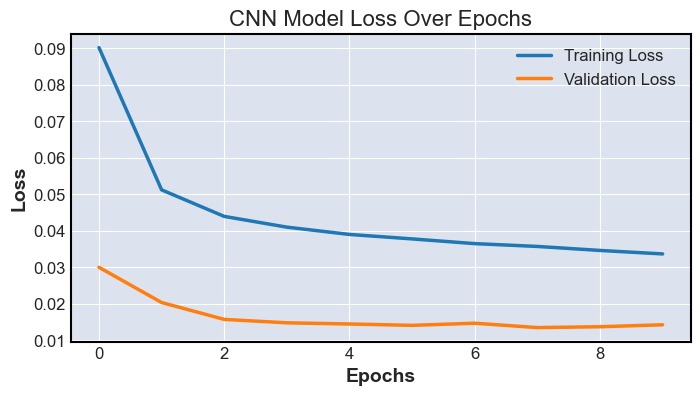

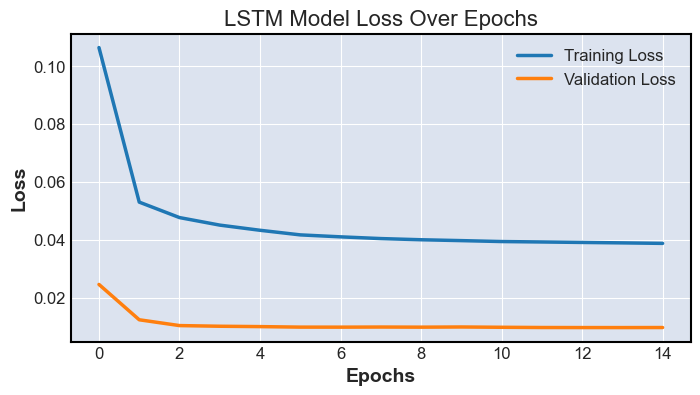

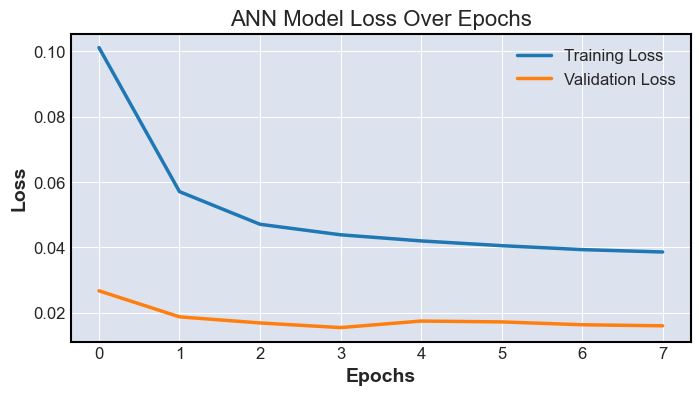

In [72]:
# CNN PLot
plt.figure(figsize=(8, 4))
plt.plot(history_cnn.history['loss'], label='Training Loss', linewidth=2.5)
plt.plot(history_cnn.history['val_loss'], label='Validation Loss', linewidth=2.5)
plt.title('CNN Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True)
plt.show()

#LSTM Plot
plt.figure(figsize=(8, 4))
plt.plot(history_lstm.history['loss'], label='Training Loss', linewidth=2.5)
plt.plot(history_lstm.history['val_loss'], label='Validation Loss', linewidth=2.5)
plt.title('LSTM Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True)
plt.show()

# ANN Plot
plt.figure(figsize=(8, 4))
plt.plot(history_ann.history['loss'], label='Training Loss', linewidth=2.5)
plt.plot(history_ann.history['val_loss'], label='Validation Loss', linewidth=2.5)
plt.title('ANN Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True)
plt.show()

### Evaluation of the models

CNN - MAE: 310.22, MSE: 181139.97, RMSE: 425.61
LSTM - MAE: 260.67, MSE: 106366.92, RMSE: 326.14
ANN - MAE: 335.00, MSE: 219243.87, RMSE: 468.23


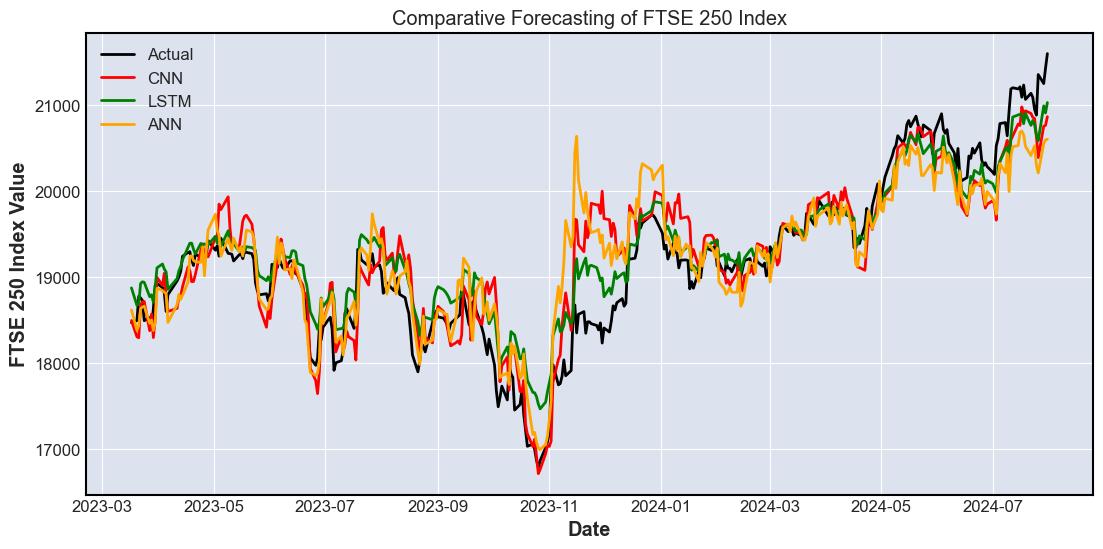

In [74]:
# Evaluation
def evaluate_model(true_values, predictions, model_name):
    # Ensuring predicted and true values have the same length for comparison
    min_length = min(len(true_values), len(predictions))
    true_values = true_values[:min_length]
    predictions = predictions[:min_length]

    mae = mean_absolute_error(true_values, predictions) # Now compares arrays of the same length
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    print(f"{model_name} - MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")

# Evaluate models on test data, ensuring consistent lengths
evaluate_model(test_data['Target'], cnn_predictions, "CNN")
evaluate_model(test_data['Target'], lstm_predictions, "LSTM")
evaluate_model(test_data['Target'], ann_predictions, "ANN")

# Comparative Analysis
plt.figure(figsize=(13, 6))

# Adjust the slicing of arima_forecast to match the length of test_data['Close'][window_size:]
plt.plot(test_data.index[window_size:], test_data['Close'][window_size:], label='Actual', color='black')
plt.plot(test_data.index[window_size:], cnn_predictions, label='CNN', color='red')
plt.plot(test_data.index[window_size:], lstm_predictions, label='LSTM', color='green')
plt.plot(test_data.index[window_size:], ann_predictions, label='ANN', color='orange')

plt.title('Comparative Forecasting of FTSE 250 Index')
plt.xlabel('Date')
plt.ylabel('FTSE 250 Index Value')
plt.legend()
plt.show()

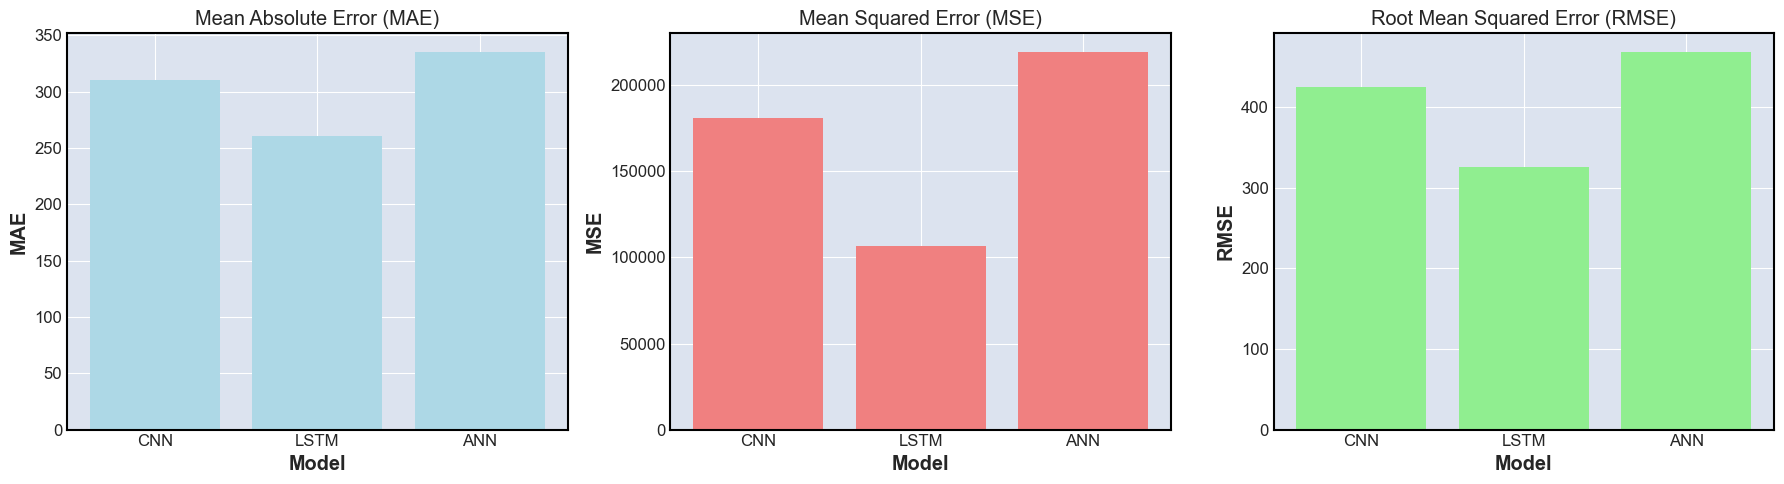

In [67]:


def evaluate_model(true_values, predictions):
    min_length = min(len(true_values), len(predictions))
    true_values = true_values[:min_length]
    predictions = predictions[:min_length]
    
    mae = mean_absolute_error(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse

# Assuming you have the true values and predictions for each model
true_values = test_data['Close'][window_size:]
models_predictions = {
    'CNN': cnn_predictions,
    'LSTM': lstm_predictions,
    'ANN': ann_predictions
}

# Compute metrics for each model
metrics = {model: evaluate_model(true_values, preds) for model, preds in models_predictions.items()}

# Prepare data for plotting
models = list(metrics.keys())
mae_values = [metrics[model][0] for model in models]
mse_values = [metrics[model][1] for model in models]
rmse_values = [metrics[model][2] for model in models]

# Plot MAE, MSE, and RMSE
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# MAE
axs[0].bar(models, mae_values, color='lightblue')
axs[0].set_title('Mean Absolute Error (MAE)')
axs[0].set_xlabel('Model')
axs[0].set_ylabel('MAE')

# MSE
axs[1].bar(models, mse_values, color='lightcoral')
axs[1].set_title('Mean Squared Error (MSE)')
axs[1].set_xlabel('Model')
axs[1].set_ylabel('MSE')

# RMSE
axs[2].bar(models, rmse_values, color='lightgreen')
axs[2].set_title('Root Mean Squared Error (RMSE)')
axs[2].set_xlabel('Model')
axs[2].set_ylabel('RMSE')

plt.tight_layout()
plt.show()


### Predicting 15th and 30th day from today using predicted data

CNN - MAE: 1709.88, MSE: 3062340.08, RMSE: 1749.95
LSTM - MAE: 1410.56, MSE: 2110724.11, RMSE: 1452.83
ANN - MAE: 1700.80, MSE: 3026377.29, RMSE: 1739.65

Comparison of 15th and 30th Day Predictions with Actual Values:
15th Day (2024-06-18): Actual: 20409.90, CNN: 18904.01, LSTM: 19153.27, ANN: 18845.95
30th Day (2024-07-02): Actual: 20194.50, CNN: 18947.04, LSTM: 19394.96, ANN: 19249.05


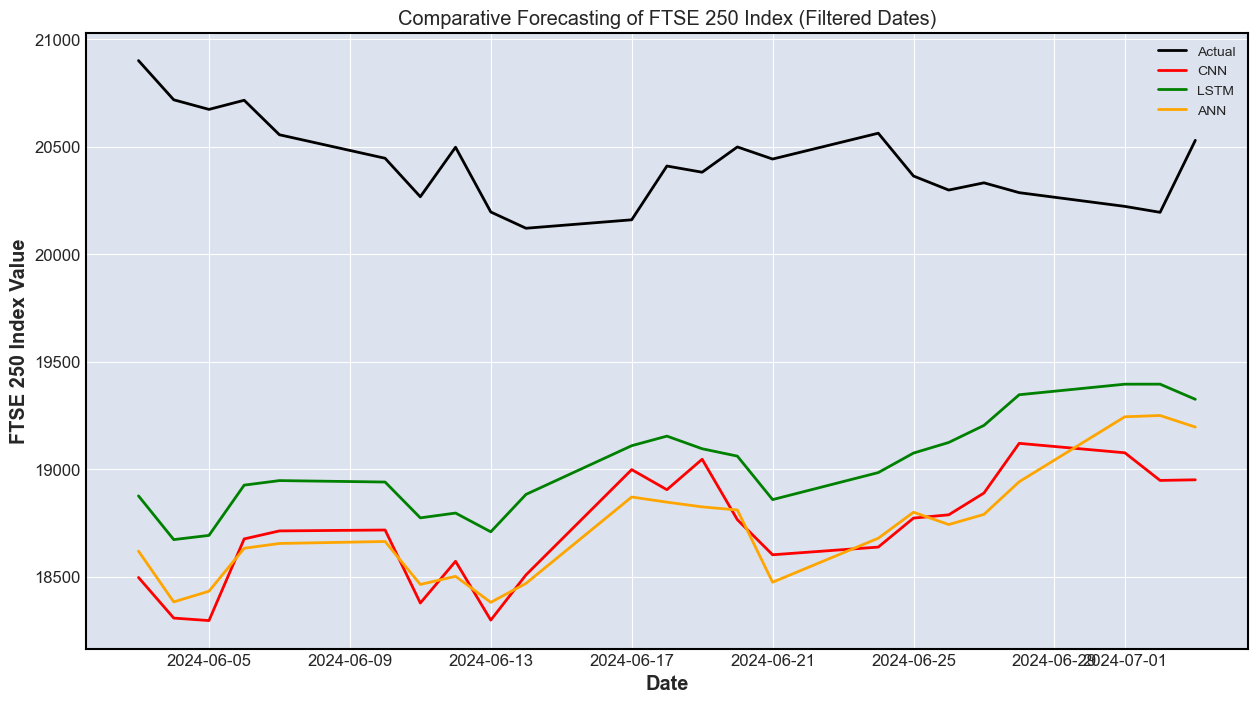

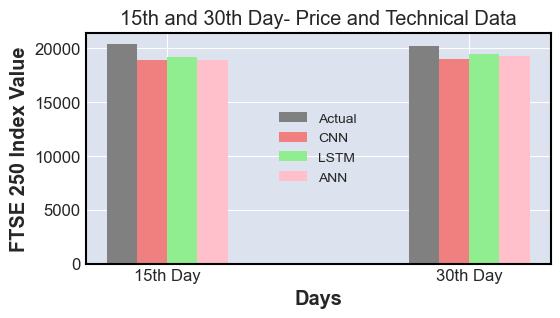

In [73]:


def evaluate_model(true_values, predictions, model_name):
    min_length = min(len(true_values), len(predictions))
    true_values = true_values[:min_length]
    predictions = predictions[:min_length]

    mae = mean_absolute_error(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    print(f"{model_name} - MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")

# Specify the date range for plotting (convert to datetime format)
start_date = datetime.datetime.strptime('2024-06-01', '%Y-%m-%d').date()
end_date = datetime.datetime.strptime('2024-07-03', '%Y-%m-%d').date()

# Filter the test data for the specified date range
filtered_test_data = test_data.loc[(test_data.index >= start_date) & (test_data.index <= end_date)]

# Get the corresponding index positions from the filtered test data
filtered_indices = filtered_test_data.index.get_indexer(filtered_test_data.index)

# Filter the predictions using these index positions
filtered_cnn_predictions = np.array(cnn_predictions)[filtered_indices]
filtered_lstm_predictions = np.array(lstm_predictions)[filtered_indices]
filtered_ann_predictions = np.array(ann_predictions)[filtered_indices]

# Evaluate models on the filtered test data
evaluate_model(filtered_test_data['Close'], filtered_cnn_predictions, "CNN")
evaluate_model(filtered_test_data['Close'], filtered_lstm_predictions, "LSTM")
evaluate_model(filtered_test_data['Close'], filtered_ann_predictions, "ANN")

# Extracting the 15th and 30th day's actual and predicted values
day_15 = 11  # Index for 15th day (0-based index, so 11 corresponds to 15th day)
day_30 = 21  # Index for 30th day

# Get actual values and predictions for the 15th and 30th day
actual_15 = filtered_test_data['Close'].iloc[day_15]
cnn_15 = filtered_cnn_predictions[day_15]
lstm_15 = filtered_lstm_predictions[day_15]
ann_15 = filtered_ann_predictions[day_15]

actual_30 = filtered_test_data['Close'].iloc[day_30]
cnn_30 = filtered_cnn_predictions[day_30]
lstm_30 = filtered_lstm_predictions[day_30]
ann_30 = filtered_ann_predictions[day_30]

# Print comparison for the 15th and 30th days
print("\nComparison of 15th and 30th Day Predictions with Actual Values:")
print(f"15th Day ({filtered_test_data.index[day_15]}): Actual: {actual_15:.2f}, CNN: {cnn_15:.2f}, LSTM: {lstm_15:.2f}, ANN: {ann_15:.2f}")
print(f"30th Day ({filtered_test_data.index[day_30]}): Actual: {actual_30:.2f}, CNN: {cnn_30:.2f}, LSTM: {lstm_30:.2f}, ANN: {ann_30:.2f}")

# Plotting the actual and predicted values for the entire month
plt.figure(figsize=(15, 8))

# Plot the actual values
plt.plot(filtered_test_data.index, filtered_test_data['Close'], label='Actual', color='black')

# Plot the CNN, LSTM, and ANN predictions
plt.plot(filtered_test_data.index, filtered_cnn_predictions, label='CNN', color='red')
plt.plot(filtered_test_data.index, filtered_lstm_predictions, label='LSTM', color='green')
plt.plot(filtered_test_data.index, filtered_ann_predictions, label='ANN', color='orange')

plt.title('Comparative Forecasting of FTSE 250 Index (Filtered Dates)')
plt.xlabel('Date')
plt.ylabel('FTSE 250 Index Value')

# Adjust legend location to the top right and make it smaller
plt.legend(loc='upper right', fontsize='small')

# Display the plot
plt.show()

# Pictorial representation for the 15th and 30th day comparison
fig, ax = plt.subplots(figsize=(6, 3))

# Bar labels and values for the 15th and 30th days
labels = ['15th Day', '30th Day']
actual_values = [actual_15, actual_30]
cnn_values = [cnn_15, cnn_30]
lstm_values = [lstm_15, lstm_30]
ann_values = [ann_15, ann_30]

# X positions for the bars
x = np.arange(len(labels))

# Bar width
bar_width = 0.1

# Plot bars for actual and model predictions with light colors
ax.bar(x - bar_width, actual_values, bar_width, label='Actual', color='grey')
ax.bar(x, cnn_values, bar_width, label='CNN', color='lightcoral')
ax.bar(x + bar_width, lstm_values, bar_width, label='LSTM', color='lightgreen')
ax.bar(x + 2 * bar_width, ann_values, bar_width, label='ANN', color='pink')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Days')
ax.set_ylabel('FTSE 250 Index Value')
ax.set_title('15th and 30th Day- Price and Technical Data')
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(labels)

# Adjust legend location to the top right and make it smaller
ax.legend(loc='center', fontsize='small')

# Display the bar plot
plt.show()
